In [70]:
# Load stored data

%store -r stats

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import geopandas as gpd
from shapely.geometry import box, Point, Polygon, MultiPoint
import pyproj
from shapely.ops import transform
from functools import partial
import warnings

warnings.filterwarnings("ignore")

In [72]:
stats

<xarray.Dataset>
Dimensions:                  (tracks: 21727, times: 100)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 25331 25332 25333 25334
  * times                    (times) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Data variables: (12/37)
    track_duration           (tracks) int32 7 3 18 15 2 9 6 2 ... 3 2 2 4 1 3 8
    base_time                (tracks, times) datetime64[ns] 2022-06-01T00:01:...
    meanlat                  (tracks, times) float32 28.89 28.9 ... nan nan
    meanlon                  (tracks, times) float32 -95.67 -95.68 ... nan nan
    area                     (tracks, times) float32 20.5 19.0 15.25 ... nan nan
    cloudnumber              (tracks, times) float64 1.0 4.0 6.0 ... nan nan nan
    ...                       ...
    start_split_tracknumber  (tracks) float64 nan nan nan ... 1.167e+04 nan nan
    start_split_timeindex    (tracks) float64 nan nan nan nan ... 16.0 nan nan
    start_split_cloudnumber  (tracks) float64 nan nan nan nan ... 1.0 nan nan
    end_merge_tracknumber    (tracks) float64 nan nan nan nan ... nan nan nan
    end_merge_timeindex      (tracks) float64 nan nan nan nan ... nan nan nan
    end_merge_cloudnumber    (tracks) float64 nan nan nan nan ... nan nan nan
Attributes:
    Title:                 Statistics of each track
    Institution:           Pacific Northwest National Laboratory
    Contact:               Zhe Feng, zhe.feng@pnnl.gov
    Created_on:            Mon Jul 10 21:16:26 2023
    startdate:             20220601.0000
    enddate:               20220630.2359
    timegap_hour:          0.25
    time_resolution_hour:  0.0833
    pixel_radius_km:       0.5

# Calculate average wind direction



In [73]:
# Calculate the average wind direction

import xarray as xr
import numpy as np
import pandas as pd

# Load the NetCDF file
file_path = 'C:/Users/omitu/Documents/GitHub/Urbanization-and-Climate-Change/Second_part/wind_components.nc' 
wind_data = xr.open_dataset(file_path)

# Extract the u-component and v-component of wind speed
u_component = wind_data['u'].values
v_component = wind_data['v'].values

# Sum the u-component and v-component across all times, latitudes, and longitudes
sum_u = u_component.sum()
sum_v = v_component.sum()

# Compute the average wind direction
avg_wind_direction_rad = np.arctan2(sum_v, sum_u)
avg_wind_direction_deg = np.degrees(avg_wind_direction_rad)

# Print the average wind direction in degrees
print(f'Average Wind Direction: {avg_wind_direction_deg:.2f}°')


Average Wind Direction: 125.37°


# Hypothetical coordinate system

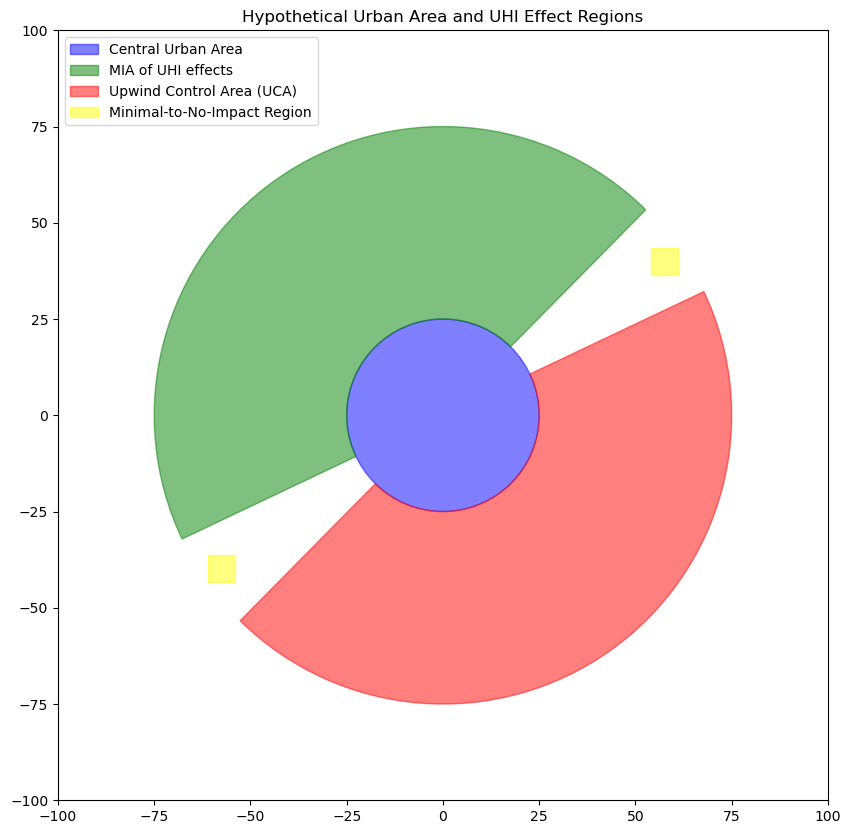

In [74]:


# Definitions
city_center = (0, 0)  # You can adjust this to any desired city center
urban_radius = 25
downwind_start = 25
downwind_end = 75
sector_angle = 160  # in degrees
rectangle_area = 50  # in km^2
rectangle_width = np.sqrt(rectangle_area)
rectangle_height = rectangle_width
mean_wind_angle = avg_wind_direction_deg  # in degrees

# Creating the plot
fig, ax = plt.subplots(figsize=(10, 10))


# Drawing the urban region
urban_circle = patches.Circle(city_center, urban_radius, color='blue', alpha=0.5, label='Central Urban Area')
ax.add_patch(urban_circle)

# Drawing the downwind MIA region
downwind_wedge = patches.Wedge(city_center, downwind_end, mean_wind_angle-(sector_angle/2), mean_wind_angle+(sector_angle/2), 
                               width=downwind_end - downwind_start, color='green', alpha=0.5, label='MIA of UHI effects')
ax.add_patch(downwind_wedge)

# Drawing the upwind control area
upwind_wedge = patches.Wedge(city_center, downwind_end, mean_wind_angle+180-(sector_angle/2), mean_wind_angle+180+(sector_angle/2), 
                             width=downwind_end - downwind_start, color='red', alpha=0.5, label='Upwind Control Area (UCA)')
ax.add_patch(upwind_wedge)

# Computing orthogonal direction to the wind for placing the minimal impact regions
orthogonal_angle = mean_wind_angle + 90

# Calculate starting points for the orthogonal rectangles
start_x1 = city_center[0] + downwind_end * np.cos(np.radians(orthogonal_angle))
start_y1 = city_center[1] + downwind_end * np.sin(np.radians(orthogonal_angle))
start_x2 = city_center[0] - downwind_end * np.cos(np.radians(orthogonal_angle))
start_y2 = city_center[1] - downwind_end * np.sin(np.radians(orthogonal_angle))

# Drawing the orthogonal minimal-to-no-impact regions
rectangle1 = patches.Rectangle((start_x1, start_y1), rectangle_width, rectangle_height, 
                               color='yellow', alpha=0.5, label='Minimal-to-No-Impact Region')
rectangle2 = patches.Rectangle((start_x2-rectangle_width, start_y2-rectangle_height), rectangle_width, rectangle_height, 
                               color='yellow', alpha=0.5)
ax.add_patch(rectangle1)
ax.add_patch(rectangle2)

# Setting plot properties
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_aspect('equal', 'box')
ax.set_title("Hypothetical Urban Area and UHI Effect Regions")
ax.legend(loc='upper left')

plt.show()


## Now we want to define the actual coordinate system for our analysis

### First, we define thecenter of the urban area

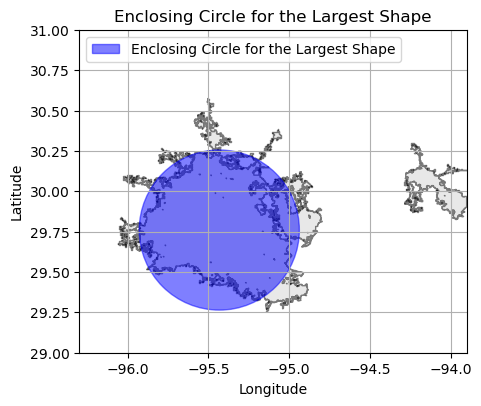

In [75]:



# Load the shapefile
shapefile_path = "C:/Users/omitu/Documents/GitHub/Urbanization-and-Climate-Change/Second_part/data/shapefile/2022_Shapefile/2022_Developed_Shapefile_1.shp"
gdf = gpd.read_file(shapefile_path)

# Get the largest shape by area
largest_shape = gdf.iloc[gdf['geometry'].area.idxmax()]

# Extract the individual shapes from the MultiPolygon
shapes = list(largest_shape['geometry'].geoms)

# List to store the results
shape_data = []

# For each individual shape, compute the enclosing circle, area, and centroid
for shape in shapes:
    # Compute the minimum enclosing circle for the shape
    enclosing_circle = shape.convex_hull.minimum_rotated_rectangle.boundary.minimum_rotated_rectangle.buffer(0.01).boundary
    enclosing_circle_center = Point(enclosing_circle.centroid.x, enclosing_circle.centroid.y)
    enclosing_circle_radius = enclosing_circle.distance(enclosing_circle_center)
    
    # Compute the area of the shape
    shape_area = shape.area
    
    # Determine the centroid of the shape
    shape_centroid = shape.centroid
    
    # Store the results
    shape_data.append({
        "enclosing_circle_center": (enclosing_circle_center.x, enclosing_circle_center.y),
        "enclosing_circle_radius": enclosing_circle_radius,
        "shape_area": shape_area,
        "shape_centroid": (shape_centroid.x, shape_centroid.y)
    })

# Identify the shape with the largest enclosing circle
largest_enclosing_circle_data = max(shape_data, key=lambda x: x["enclosing_circle_radius"])

# Plot the shapefile and the enclosing circle for the largest shape
fig, ax = plt.subplots(figsize=(5, 5))
gdf.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

# Drawing the enclosing circle for the largest shape
enclosing_circle = patches.Circle( largest_enclosing_circle_data["enclosing_circle_center"], 
                                  largest_enclosing_circle_data["enclosing_circle_radius"], 
                                  color='blue', alpha=0.5, label='Enclosing Circle for the Largest Shape')
ax.add_patch(enclosing_circle)

# Setting plot properties
ax.set_xlim(-96.3, -93.9)
ax.set_ylim(29, 31)
ax.set_aspect('equal', 'box')
ax.set_title("Enclosing Circle for the Largest Shape")
ax.legend(loc='upper left')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

plt.show()




### Now we add the other wedges

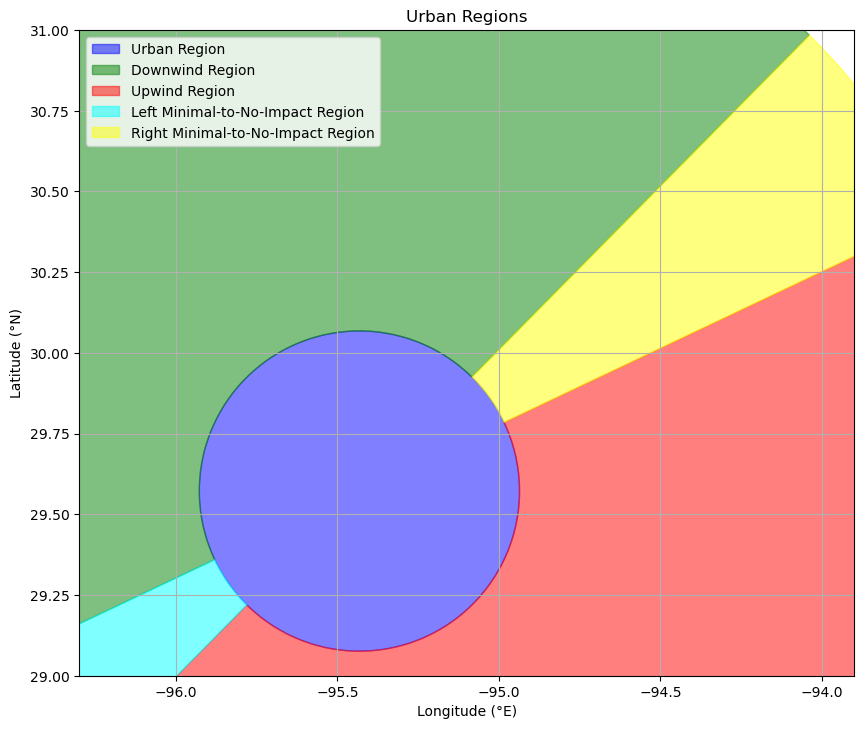

In [76]:
# Using the data from the largest enclosing circle obtained previously:
city_center = (-95.43207102398061, 29.5719) # largest_enclosing_circle_data["enclosing_circle_center"]
urban_radius = largest_enclosing_circle_data["enclosing_circle_radius"]

# Updated definitions
downwind_start = 100
downwind_end = 100
sector_angle = 160  # in degrees
mean_wind_angle = avg_wind_direction_deg  # in degrees
orthogonal_angle = mean_wind_angle + 90

# Adjust the scaling factors based on the new urban radius
downwind_start_scaled = downwind_start * urban_radius / 25
downwind_end_scaled = downwind_end * urban_radius / 25

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Drawing the urban region using the enclosing circle
urban_circle = patches.Circle(city_center, urban_radius, color='blue', alpha=0.5, label='Urban Region')
ax.add_patch(urban_circle)

# Drawing the downwind MIA region attached to the urban circle
downwind_wedge = patches.Wedge(city_center, downwind_end_scaled, mean_wind_angle-(sector_angle/2), mean_wind_angle+(sector_angle/2), 
                               width=downwind_end_scaled - urban_radius, color='green', alpha=0.5, label='Downwind Region')
ax.add_patch(downwind_wedge)

# Drawing the upwind control area attached to the urban circle
upwind_wedge = patches.Wedge(city_center, downwind_end_scaled, mean_wind_angle+180-(sector_angle/2), mean_wind_angle+180+(sector_angle/2), 
                             width=downwind_end_scaled - urban_radius, color='red', alpha=0.5, label='Upwind Region')
ax.add_patch(upwind_wedge)

# Drawing the Minimal-to-No-Impact Areas as the remaining sectors
right_no_impact_wedge = patches.Wedge(city_center, downwind_end_scaled, mean_wind_angle+180+(sector_angle/2), mean_wind_angle-(sector_angle/2), 
                                    width=downwind_end_scaled - urban_radius, color='yellow', alpha=0.5, label='Right Minimal-to-No-Impact Region')
left_no_impact_wedge = patches.Wedge(city_center, downwind_end_scaled, mean_wind_angle+(sector_angle/2), mean_wind_angle+180-(sector_angle/2), 
                                     width=downwind_end_scaled - urban_radius, color='cyan', alpha=0.5, label='Left Minimal-to-No-Impact Region')
ax.add_patch(left_no_impact_wedge)
ax.add_patch(right_no_impact_wedge)

# Adjust the plot properties to fit all regions
buffer = 5 * urban_radius
ax.set_xlim(-96.3, -93.9)
ax.set_ylim(29, 31)
ax.set_aspect('equal', 'box')
ax.set_title("Urban Regions")
ax.legend(loc='upper left')

plt.xlabel("Longitude (°E)")
plt.ylabel("Latitude (°N)")
plt.grid(True)

plt.show()


### Putting it all together

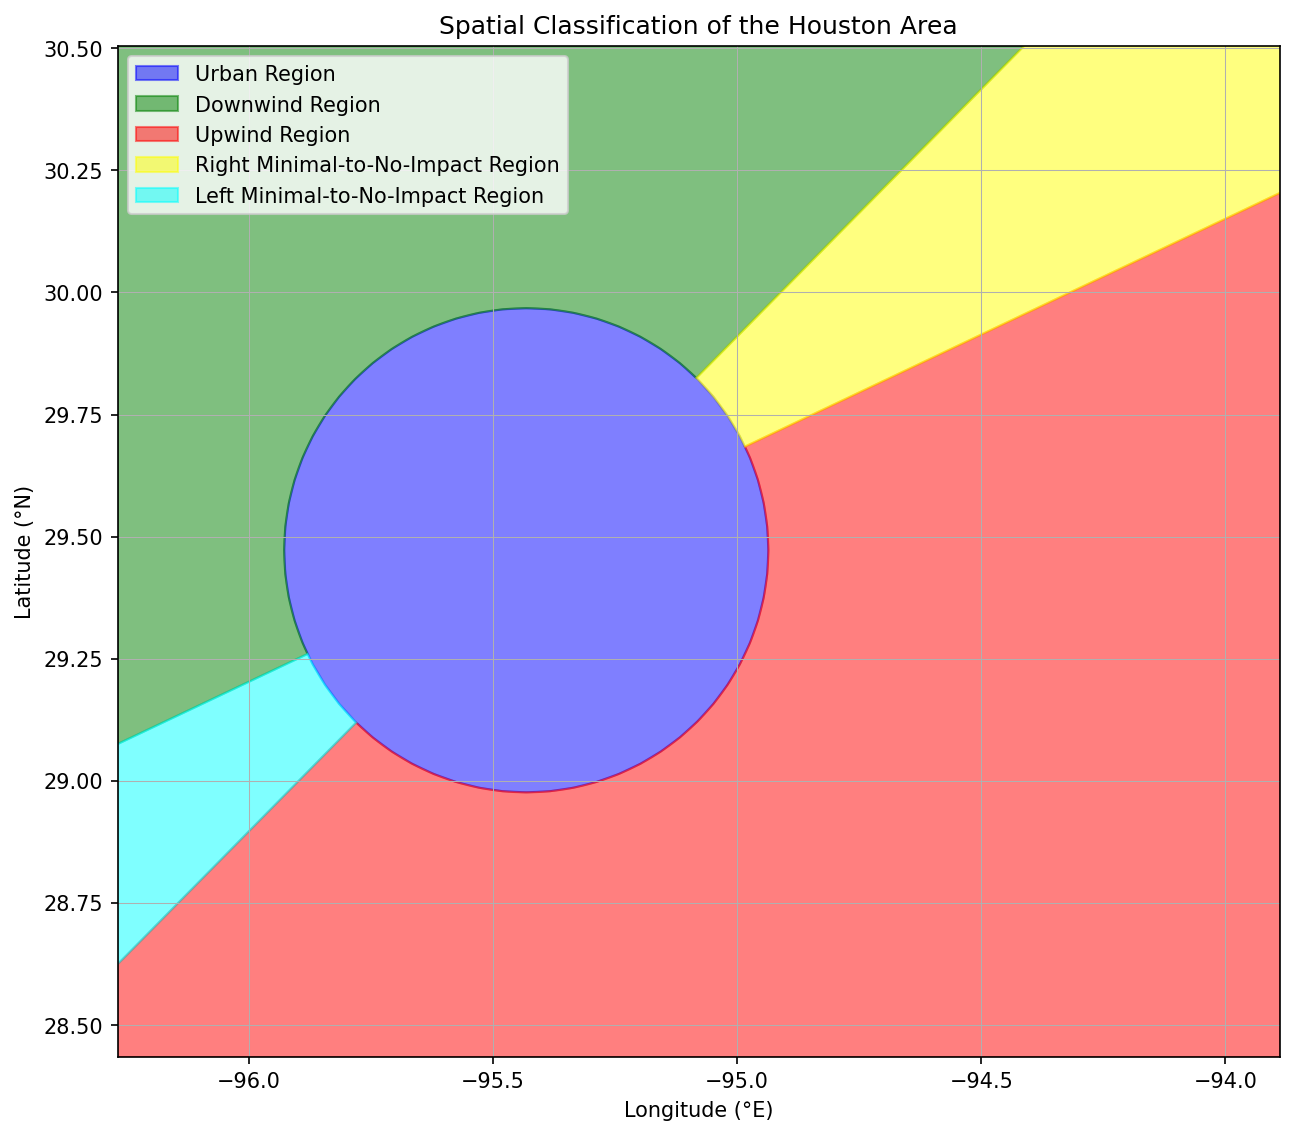

In [85]:

# Function to create an extended wedge-shaped polygon from the circle edge
def create_extended_wedge(center, inner_radius, outer_radius, angle_start, angle_end, num_points=100):
    angle_start_rad = np.radians(angle_start)
    angle_end_rad = np.radians(angle_end)
    inner_angles = np.linspace(angle_start_rad, angle_end_rad, num_points)
    outer_angles = np.linspace(angle_end_rad, angle_start_rad, num_points)
    inner_points = [(center[0] + inner_radius * np.cos(a), center[1] + inner_radius * np.sin(a)) for a in inner_angles]
    outer_points = [(center[0] + outer_radius * np.cos(a), center[1] + outer_radius * np.sin(a)) for a in outer_angles]
    return Polygon(inner_points + outer_points + [inner_points[0]])

# Load the shapefile
shapefile_path = "C:/Users/omitu/Documents/GitHub/Urbanization-and-Climate-Change/Second_part/data/shapefile/2022_Shapefile/2022_Developed_Shapefile_1.shp"
gdf = gpd.read_file(shapefile_path)

# Get the largest shape by area
largest_shape = gdf.iloc[gdf['geometry'].area.idxmax()]

# Extract the individual shapes from the MultiPolygon
shapes = list(largest_shape['geometry'].geoms)

# List to store the results
shape_data = []

# For each individual shape, compute the enclosing circle, area, and centroid
for shape in shapes:
    enclosing_circle = shape.convex_hull.minimum_rotated_rectangle.boundary.minimum_rotated_rectangle.buffer(0.01).boundary
    enclosing_circle_center = Point(enclosing_circle.centroid.x, enclosing_circle.centroid.y)
    enclosing_circle_radius = enclosing_circle.distance(enclosing_circle_center)
    shape_area = shape.area
    shape_centroid = shape.centroid
    shape_data.append({
        "enclosing_circle_center": (enclosing_circle_center.x, enclosing_circle_center.y),
        "enclosing_circle_radius": enclosing_circle_radius,
        "shape_area": shape_area,
        "shape_centroid": (shape_centroid.x, shape_centroid.y)
    })

# Identify the shape with the largest enclosing circle
largest_enclosing_circle_data = max(shape_data, key=lambda x: x["enclosing_circle_radius"])

# Using the data from the largest enclosing circle obtained previously:
city_center = (-95.43207102398061, 29.4719)
urban_radius = largest_enclosing_circle_data["enclosing_circle_radius"]

# Updated definitions
downwind_start = 100
downwind_end = 100
sector_angle = 160  # in degrees
mean_wind_angle = avg_wind_direction_deg  # in degrees

# Adjust the scaling factors based on the new urban radius
downwind_start_scaled = downwind_start * urban_radius / 25
downwind_end_scaled = downwind_end * urban_radius / 25

# Define the bounding box for clipping
minx, maxx, miny, maxy = -96.26935272216797, -93.88798065185547, 28.43370361328125, 30.50552444458008
bounding_box = box(minx, miny, maxx, maxy)

# Create the urban circle as a polygon
urban_circle_poly = Point(city_center).buffer(urban_radius)


# Create the extended wedges
downwind_wedge_poly = create_extended_wedge(city_center, urban_radius, downwind_end_scaled, mean_wind_angle-(sector_angle/2), mean_wind_angle+(sector_angle/2))
upwind_wedge_poly = create_extended_wedge(city_center, urban_radius, downwind_end_scaled, mean_wind_angle+180-(sector_angle/2), mean_wind_angle+180+(sector_angle/2))
right_no_impact_wedge_poly = create_extended_wedge(city_center, urban_radius, downwind_end_scaled, mean_wind_angle-180+(sector_angle/2), mean_wind_angle-(sector_angle/2))
left_no_impact_wedge_poly = create_extended_wedge(city_center, urban_radius, downwind_end_scaled, mean_wind_angle+(sector_angle/2), mean_wind_angle+180-(sector_angle/2))

# Clip the regions to the bounding box
clipped_urban_circle = urban_circle_poly.intersection(bounding_box)
clipped_downwind_wedge = downwind_wedge_poly.intersection(bounding_box)
clipped_upwind_wedge = upwind_wedge_poly.intersection(bounding_box)
clipped_right_no_impact_wedge = right_no_impact_wedge_poly.intersection(bounding_box)
clipped_left_no_impact_wedge = left_no_impact_wedge_poly.intersection(bounding_box)

# Plotting the clipped regions
fig, ax = plt.subplots(figsize=(10, 10), dpi=150)

# Function to plot a clipped region
def plot_clipped_region(ax, clipped_region, color, label):
    if not clipped_region.is_empty:
        x, y = clipped_region.exterior.xy
        ax.fill(x, y, color=color, alpha=0.5, label=label)

# Plot each region with consistent colors
plot_clipped_region(ax, clipped_urban_circle, 'blue', 'Urban Region')
plot_clipped_region(ax, clipped_downwind_wedge, 'green', 'Downwind Region')
plot_clipped_region(ax, clipped_upwind_wedge, 'red', 'Upwind Region')
plot_clipped_region(ax, clipped_right_no_impact_wedge, 'yellow', 'Right Minimal-to-No-Impact Region')
plot_clipped_region(ax, clipped_left_no_impact_wedge, 'cyan', 'Left Minimal-to-No-Impact Region')

# Setting plot properties
ax.set_xlim(-96.26935272216797, -93.88798065185547)
ax.set_ylim(28.43370361328125, 30.50552444458008)
ax.set_aspect('equal', 'box')
ax.set_title("Spatial Classification of the Houston Area")
ax.legend(loc='upper left')
plt.xlabel("Longitude (°E)")
plt.ylabel("Latitude (°N)")
plt.grid(linewidth=0.5)
plt.show()


In [78]:
%store clipped_urban_circle clipped_downwind_wedge clipped_upwind_wedge

Stored 'clipped_urban_circle' (Polygon)
Stored 'clipped_downwind_wedge' (Polygon)
Stored 'clipped_upwind_wedge' (Polygon)


In [79]:
city_center

(-95.43207102398061, 29.4719)

In [80]:
urban_longitude = city_center[0]
urban_radius_deg = urban_radius

# Calculate the westernmost and easternmost longitudes within the urban radius
westernmost_longitude = urban_longitude - urban_radius_deg
easternmost_longitude = urban_longitude + urban_radius_deg

(westernmost_longitude, easternmost_longitude)


(-95.92796070275301, -94.93618134520821)

In [81]:
%store urban_radius city_center

Stored 'urban_radius' (float)
Stored 'city_center' (tuple)


### VErify that the wedges do not extend beyond the bounding box

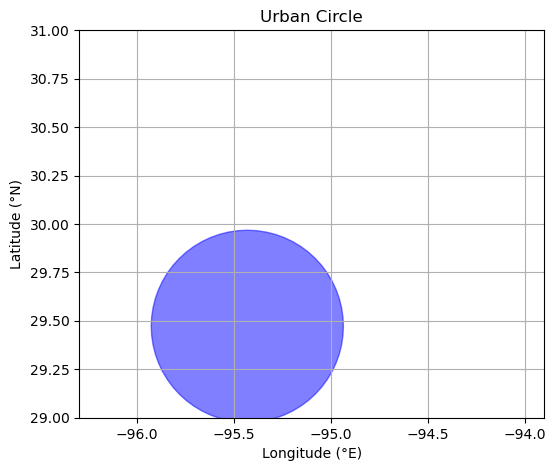

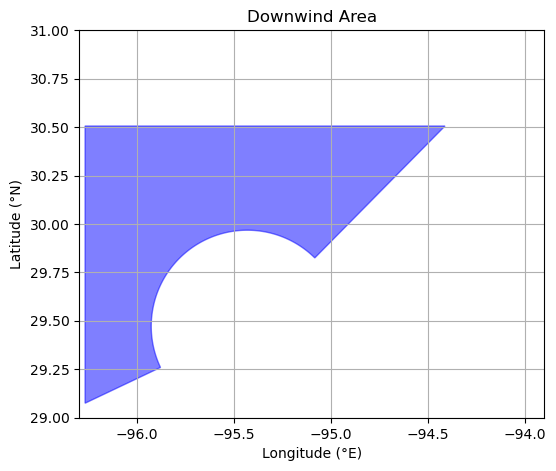

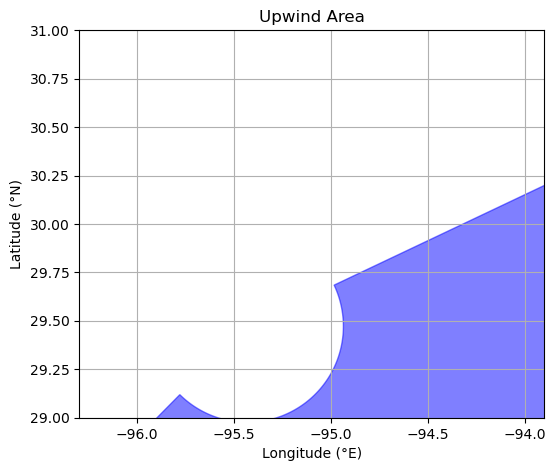

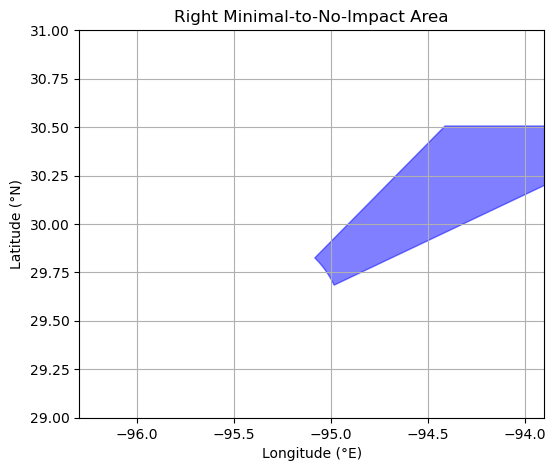

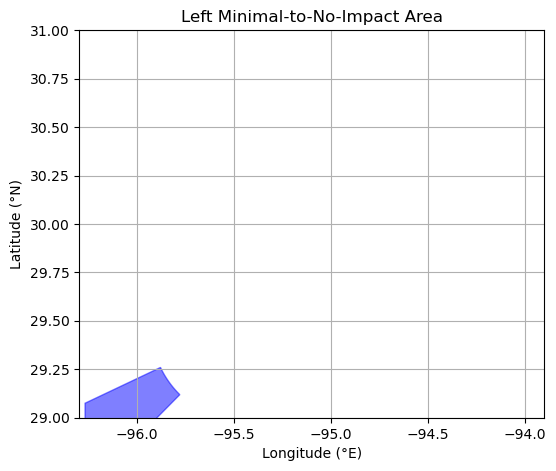

In [82]:
import matplotlib.pyplot as plt

# Function to plot a single wedge
def plot_wedge(wedge, title, xlims, ylims):
    fig, ax = plt.subplots(figsize=(6, 6))
    if not wedge.is_empty:
        x, y = wedge.exterior.xy
        ax.fill(x, y, color='blue', alpha=0.5)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_aspect('equal', 'box')
    ax.set_title(title)
    plt.xlabel("Longitude (°E)")
    plt.ylabel("Latitude (°N)")
    plt.grid(True)
    plt.show()

# Define the limits for the plots
xlims = (-96.3, -93.9)
ylims = (29, 31)

# Plot each wedge individually
plot_wedge(clipped_urban_circle, "Urban Circle", xlims, ylims)
plot_wedge(clipped_downwind_wedge, "Downwind Area", xlims, ylims)
plot_wedge(clipped_upwind_wedge, "Upwind Area", xlims, ylims)
plot_wedge(clipped_right_no_impact_wedge, "Right Minimal-to-No-Impact Area", xlims, ylims)
plot_wedge(clipped_left_no_impact_wedge, "Left Minimal-to-No-Impact Area", xlims, ylims)

## Calcuate the areas of the zones

In [83]:


# Function for projection transformation
def project_to_utm(geom):
    project = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:4326'),  # source coordinate system (WGS84)
        pyproj.Proj(init='epsg:32615')  # destination coordinate system (UTM Zone 15N for Houston)
    )
    return transform(project, geom)

# Project and calculate areas
clipped_urban_circle_proj = project_to_utm(clipped_urban_circle)
clipped_downwind_wedge_proj = project_to_utm(clipped_downwind_wedge)
clipped_upwind_wedge_proj = project_to_utm(clipped_upwind_wedge)
clipped_right_no_impact_wedge_proj = project_to_utm(clipped_right_no_impact_wedge)
clipped_left_no_impact_wedge_proj = project_to_utm(clipped_left_no_impact_wedge)

# Calculate areas in square kilometers
area_urban_km2 = clipped_urban_circle_proj.area / 1e6
area_downwind_km2 = clipped_downwind_wedge_proj.area / 1e6
area_upwind_km2 = clipped_upwind_wedge_proj.area / 1e6
area_right_no_impact_km2 = clipped_right_no_impact_wedge_proj.area / 1e6
area_left_no_impact_km2 = clipped_left_no_impact_wedge_proj.area / 1e6

# Print the areas
print("Urban Area (km²):", area_urban_km2)
print("Downwind Area (km²):", area_downwind_km2)
print("Upwind Area (km²):", area_upwind_km2)
print("Right Minimal-to-No-Impact Area (km²):", area_right_no_impact_km2)
print("Left Minimal-to-No-Impact Area (km²):", area_left_no_impact_km2)


Urban Area (km²): 8297.058074474882
Downwind Area (km²): 13037.57629911623
Upwind Area (km²): 25178.00421017681
Right Minimal-to-No-Impact Area (km²): 4910.246689746534
Left Minimal-to-No-Impact Area (km²): 1576.3740896775132


### Store the areas

In [84]:
%store area_downwind_km2 area_upwind_km2 area_urban_km2

Stored 'area_downwind_km2' (float)
Stored 'area_upwind_km2' (float)
Stored 'area_urban_km2' (float)
